<a href="https://colab.research.google.com/github/UIT-19521183/CS114.L21/blob/main/CS114.L21/Colab%20assignments/4)%20Sarcasm%20detection/Sarcasm%20Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data importing

In [78]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from nltk.tokenize.toktok import ToktokTokenizer
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU
import tensorflow as tf

In [ ]:
training_data=pd.read_json("https://raw.githubusercontent.com/UIT-19521183/CS114.L21/main/Colab%20assignments/4)%20Sarcasm%20detection/Data/Training%20data%20for%20Sarcasm%20Detection.json")

In [3]:
length = []
for x in training_data['headline']:
  length.append(len(x))
training_data['length'] = length

In [4]:
training_data.describe()

,is_sarcastic,length
count,119688.000000,119688.000000
mean,0.170685,68.115208
std,0.376235,51.366984
min,0.000000,1.000000
25%,0.000000,54.000000
50%,0.000000,61.000000
75%,0.000000,71.000000
max,1.000000,10536.000000


In [5]:
training_data.drop(index=training_data.loc[training_data['length'] > 120, :].index)

,headline,is_sarcastic,length
0,More than 90% of COVID cases in UK are Delta v...,0,67
1,Russia bus crash: At least six people killed a...,0,66
2,EURO 2020: This is your quick guide to Slovakia,0,47
3,Slovakia are competing in just their second Eu...,0,118
4,EURO 2020: This is your quick guide to Poland,0,45
...,...,...,...
119683,SPACEWALK TO BE CANCELLED AS ‘NOTHING NEEDS FI...,1,51
119684,COOGAN AND REILLY ‘ASTOUNDING’ AS REES-MOGG AN...,1,55
119685,BREXIT TIME CAPSULE DISCOVERED BURIED UNDERNEA...,1,63
119686,BOWIE DIES IN CAMERON PROTEST,1,29


In [ ]:
testing_data=pd.read_json("https://raw.githubusercontent.com/UIT-19521183/CS114.L21/main/Colab%20assignments/4)%20Sarcasm%20detection/Data/Testing%20data%20for%20Sarcasm%20Detection.json")

In [7]:
testing_data.dropna(inplace=True)

In [8]:
length = []
for x in testing_data['headline']:
  length.append(len(x))
testing_data['length'] = length

In [125]:
testing_data.describe()

,is_sarcastic,length
count,57463.000000,57463.000000
mean,0.341333,58.594365
std,0.474161,20.649676
min,0.000000,5.000000
25%,0.000000,46.000000
50%,0.000000,57.000000
75%,1.000000,69.000000
max,1.000000,188.000000


In [9]:
testing_data.drop(index=testing_data.loc[testing_data['length'] > 120, :].index)

,headline,is_sarcastic,length
0,007 to be played by intersectionality checklist,1,47
1,1 easy tip for abiding by your governor's holi...,1,62
2,10 arguments for christianity that are guarant...,1,59
3,10 awesome baby names straight out of the bible,1,47
4,10 blatantly obvious christ figures in the 'st...,1,63
...,...,...,...
57462,arnold donald: “it stopped working because the...,0,61
57463,postcard from . . . new york,0,28
57464,"shortcuts: updates from las vegas, rome and lo...",0,50
57465,"le coucou, new york: chic and cheerful",0,38


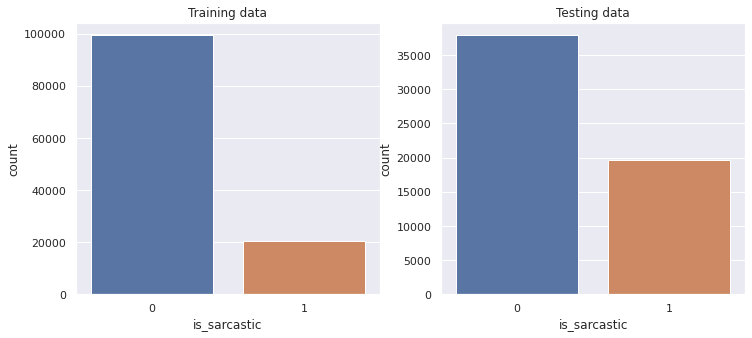

In [10]:
sns.set_theme(style="darkgrid")
fig, axs = plt.subplots(1,2, figsize = (12,5))
axs[0].set_title("Training data")
axs[1].set_title("Testing data")
sns.countplot(x='is_sarcastic', data=training_data, ax=axs[0])
sns.countplot(x='is_sarcastic', data=testing_data, ax=axs[1])

Nhìn chung số lượng headlines chính thống và châm biếm trên cả 
trainining và testing data có sự chênh lệch lớn, đặc biệt ở training data. 


---


Với training data, số lượng headline châm biếm chỉ ở mức 1/5 số lượng 
headline chính thống. Nhưng với testing data, số headline châm biến nhiều hơn 1/2 số headline chính thống (dù cả training và testing data đều có 20000 headline châm biếm).


---


=> Các model sẽ được train headline chính thống nhiều hơn nên sẽ cho kết quả phân loại chính xác hơn trên class này. Ngoài ra, tỉ lệ châm biếm/ chính thống tăng ở testing data làm cho model có xu hướng phân loại sai class châm biếm nhiều hơn nên training và testing data như trên gây khá nhiều bất lợi cho kết quả phân loại của model.

# Data preprocessing

In [11]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [12]:
testing_data=testing_data.dropna()

In [13]:
X_train=training_data['headline']
X_test=testing_data['headline']
y_train=training_data['is_sarcastic']
y_test=testing_data['is_sarcastic']

In [14]:
def lower_headline(headline): # Đưa toàn bộ headline về chữ thường
  return headline.lower()
                            
def remove_punctuation(headline): # Loại bỏ các dấu câu không cần thiết trong headline
  punctuation = [ char for char in string.punctuation ] + [u'\u201c',u'\u201d',u'\u2018',u'\u2019']
  no_punctuation = [char for char in headline if char not in punctuation]
  return "".join(no_punctuation)

# stop words là các từ thường được sử dụng nhiều trong 1 ngôn ngữ, thường mang ý nghĩa về ngữ pháp hơn là nội dung
# VD các stop words phổ biến trong tiếng Anh là: a, the, is, are,...
stop = stopwords.words('english') 
def remove_stopwords(headline): # Loại bỏ các stop words
  tokens=word_tokenize(headline)
  no_stopwords=[word for word in tokens if word not in stop]
  return " ".join(no_stopwords)

In [15]:
# chuyển tag từ vựng trong nltk thành tag tương ứng trong wordnet 
# (chỉ gắn tag cho một số loại từ vụng thông dụng: verb, noun, adj, adv)
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

# Lemmatization là kĩ thuật nhóm các từ vựng có dạng từ khác nhau lại và đưa chúng về một từ gốc duy nhất
# VD: am, is, are => be
#     car, cars, car's, cars' => car
def lemmatize_sentence(sentence):
    lemmatizer=WordNetLemmatizer()
    # chuyển câu về các tokens và tìm tag cho mỗi token trong câu
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            # nếu token không có tag thích hợp thì cứ thêm nó vào câu, khỏi cần lemmatize
            lemmatized_sentence.append(word)
        else:        
            # nếu có thì dùng tag đó để lemmatize token để đưa từ trong câu về từ gốc của nó
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)
# https://gaurav5430.medium.com/using-nltk-for-lemmatizing-sentences-c1bfff963258

In [16]:
X_train = X_train.apply(lower_headline)
X_test = X_test.apply(lower_headline)
X_train

0         more than 90% of covid cases in uk are delta v...
1         russia bus crash: at least six people killed a...
2           euro 2020: this is your quick guide to slovakia
3         slovakia are competing in just their second eu...
4             euro 2020: this is your quick guide to poland
                                ...                        
119683    spacewalk to be cancelled as ‘nothing needs fi...
119684    coogan and reilly ‘astounding’ as rees-mogg an...
119685    brexit time capsule discovered buried undernea...
119686                        bowie dies in cameron protest
119687    mps agree all-party collaboration to destroy b...
Name: headline, Length: 119688, dtype: object

In [17]:
X_train = X_train.apply(remove_punctuation)
X_test = X_test.apply(remove_punctuation)
X_train

0         more than 90 of covid cases in uk are delta va...
1         russia bus crash at least six people killed at...
2            euro 2020 this is your quick guide to slovakia
3         slovakia are competing in just their second eu...
4              euro 2020 this is your quick guide to poland
                                ...                        
119683    spacewalk to be cancelled as nothing needs fixing
119684    coogan and reilly astounding as reesmogg and j...
119685    brexit time capsule discovered buried undernea...
119686                        bowie dies in cameron protest
119687    mps agree allparty collaboration to destroy br...
Name: headline, Length: 119688, dtype: object

In [18]:
X_train = X_train.apply(remove_stopwords)
X_test = X_test.apply(remove_stopwords)
X_train

0             90 covid cases uk delta variant says minister
1         russia bus crash least six people killed bus s...
2                            euro 2020 quick guide slovakia
3         slovakia competing second european championshi...
4                              euro 2020 quick guide poland
                                ...                        
119683             spacewalk cancelled nothing needs fixing
119684            coogan reilly astounding reesmogg johnson
119685    brexit time capsule discovered buried undernea...
119686                           bowie dies cameron protest
119687    mps agree allparty collaboration destroy briti...
Name: headline, Length: 119688, dtype: object

In [19]:
X_train = X_train.apply(lemmatize_sentence)
X_test = X_test.apply(lemmatize_sentence)
X_train

0               90 covid case uk delta variant say minister
1         russia bus crash least six people kill bus sto...
2                            euro 2020 quick guide slovakia
3         slovakia compete second european championship ...
4                              euro 2020 quick guide poland
                                ...                        
119683                    spacewalk cancel nothing need fix
119684               coogan reilly astound reesmogg johnson
119685    brexit time capsule discover buried underneath...
119686                            bowie die cameron protest
119687    mp agree allparty collaboration destroy britis...
Name: headline, Length: 119688, dtype: object

# Count Vectorizer

In [21]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import plot_confusion_matrix

In [39]:
count_vector_train=CountVectorizer()
X_train_cv=count_vector_train.fit_transform(X_train)
count_vector_test=CountVectorizer(vocabulary=count_vector_train.get_feature_names())
X_test_cv=count_vector_test.fit_transform(X_test)
print(X_train_cv.shape,X_test_cv.shape)

(119688, 48319) (57463, 48319)


In [40]:
clf=SGDClassifier()
clf.fit(X_train_cv,y_train)
y_pred=clf.predict(X_test_cv)

In [41]:
print(accuracy_score(y_test, y_pred))

0.7538241999199485


In [42]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.94      0.83     37849
           1       0.76      0.40      0.53     19614

    accuracy                           0.75     57463
   macro avg       0.76      0.67      0.68     57463
weighted avg       0.76      0.75      0.73     57463



Count vectorizer cho f1-score = 0.75 không quá tốt, precision tương đương nhau trên 2 class, tuy nhiên recall của class chính thống cao hơn rất nhiều so với class châm biếm do số lượng các headlines chính thống dùng để train model nhiều hơn headlines châm biếm.

<Figure size 432x576 with 0 Axes>

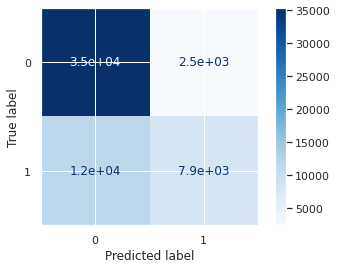

array([[35397,  2452],
       [11694,  7920]])

In [111]:
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(6,8))
plot_confusion_matrix(clf, X_test_cv, y_test,cmap=plt.cm.Blues)
plt.show()
confusion_matrix(y_test, y_pred, labels=[0,1])

Từ trái sang phải, từ trên xuống dưới:
* TN (True Negative) - Số lượng headlines chính thống dự đoán chính xác 
= 35379
* FP (False Positive) - Số lượng headlines chính thống nhưng bị dự đoán thành châm biếm = 2452
* FN (False Negative) - Số lượng headlines châm biếm nhưng dự đoán thành chính thống = 11694
* TP (True Positive) - Số lượng headlines của bài báo châm biếm dự đoán chính xác = 7920

---

=> Như vậy ta có thể thấy class châm biếm bị dự đoán sai nhiều hơn do training data có số lượng nghiêng về class chính thống nhiều hơn dẫn đến model nghiêng về dự đoán class này nhiều hơn class châm biếm.

In [ ]:
# https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
# https://stackoverflow.com/questions/30287371/countvectorizer-matrix-varies-with-new-test-data-for-classification

#TF-IDF Vectorizer

In [112]:
from sklearn.feature_extraction.text import TfidfTransformer

In [113]:
tfidf=TfidfTransformer()
X_train_tfidf=tfidf.fit_transform(X_train_cv)
X_test_tfidf=tfidf.transform(X_test_cv)
print(X_train_tfidf.shape,X_test_tfidf.shape)

(119688, 48319) (57463, 48319)


In [114]:
clf=SGDClassifier()
clf.fit(X_train_tfidf,y_train)
y_pred=clf.predict(X_test_tfidf)

In [115]:
print(accuracy_score(y_test, y_pred))

0.692358561161095


In [116]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.98      0.81     37849
           1       0.80      0.13      0.23     19614

    accuracy                           0.69     57463
   macro avg       0.74      0.56      0.52     57463
weighted avg       0.72      0.69      0.61     57463



Với TF-IDF vectorizer, sự chênh lệch về presion và recall còn rõ ràng hơn, dẫn đến f1-score giảm xuống còn 0.69

<Figure size 432x576 with 0 Axes>

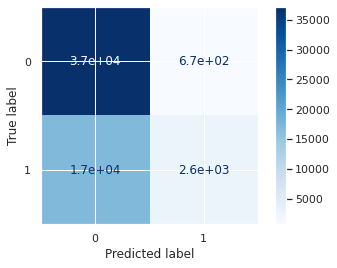

array([[37180,   669],
       [17009,  2605]])

In [135]:
plt.figure(figsize=(6,8))
plot_confusion_matrix(clf, X_test_tfidf, y_test,cmap=plt.cm.Blues)
plt.show()
confusion_matrix(y_test, y_pred, labels=[0,1])

Từ trái sang phải, từ trên xuống dưới:
* TN (True Negative) - Số lượng headlines chính thống dự đoán chính xác 
= 37180
* FP (False Positive) - Số lượng headlines chính thống nhưng bị dự đoán thành châm biếm = 669
* FN (False Negative) - Số lượng headlines châm biếm nhưng dự đoán thành chính thống = 17009
* TP (True Positive) - Số lượng headlines của bài báo châm biếm dự đoán chính xác = 2605

---

Model phân loại đúng các headlines châm biến nhiều hơn Count vectorizer nhưng lại phân loại sai nhiều hơn các headlines châm biếm. Dù TF-IDF vectorizer thường được đánh giá là tốt hơn Count vectorizer nhưng với chênh lệch số lượng headlines chính thống gấp 5 lần châm biếm ở training data như trên chỉ khiến cho TF-IDF vectorizer cho kết quả dự đoán tốt hơn chênh class chính thống và còn có phần tệ hơn trên class châm biếm.

#Word2Vec

In [118]:
import gensim
# Số chiều của các vectors biểu diễn bộ từ vựng
EMBEDDING_DIM = 50

In [119]:
data_train, data_test = [], []
for i in X_train.values:
    data_train.append(i.split())
for i in X_test.values:
    data_test.append(i.split())

In [120]:
# Tạo các Word Vectors bằng phương pháp Word2Vec
w2v_model = gensim.models.Word2Vec(sentences = data_train , size=EMBEDDING_DIM , window = 5 , min_count = 1)
# Kích thước vocabulary của training data
len(w2v_model.wv.vocab)

48665

Ta biểu diễn mỗi từ trong 48665 từ của training_data dưới dạng các vector kích thước 50 (tức mỗi vector có 50 chiều)

In [126]:
tokenizer = text.Tokenizer(num_words=48665)
tokenizer.fit_on_texts(data_train)
tokenized_train = tokenizer.texts_to_sequences(data_train)
x_train = sequence.pad_sequences(tokenized_train, maxlen = 60)
tokenized_test = tokenizer.texts_to_sequences(data_test)
x_test = sequence.pad_sequences(tokenized_test, maxlen = 60)

In [127]:
# Embedding Layer tạo thêm một vector cho các từ chưa biết hoặc các từ đệm, vector này chứa đầy các số 0.
# Như vậy kích thước vocab tăng lên 1
vocab_size = len(tokenizer.word_index) + 1

In [128]:
# Tạo weight matrix từ word2vec gensim model
def get_weight_matrix(model, vocab):
    # kích thước từ vự tăng thêm 1 do có thêm từ chưa biết
    vocab_size = len(vocab) + 1
    # khởi tạo weight matrix toàn số 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix

In [129]:
# Lấy embedding vectors từ word2vec và dùng weight của chúng cho non-trainable keras embedding layer
embedding_vectors = get_weight_matrix(w2v_model, tokenizer.word_index)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [130]:
# thêm vào model các layers chưa đào tạo
model = Sequential()
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=60, trainable=True))
# xây dựng mô hình LSTM cho model để train
model.add(LSTM(units=128))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [131]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 60, 50)            2433300   
_________________________________________________________________
lstm_15 (LSTM)               (None, 128)               91648     
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 129       
Total params: 2,525,077
Trainable params: 2,525,077
Non-trainable params: 0
_________________________________________________________________


In [132]:
history = model.fit(x_train, y_train, batch_size = 128 , validation_data = (x_test, y_test) , epochs = 3)

Epoch 1/3
936/936 [==============================] - 235s 249ms/step - loss: 0.2157 - acc: 0.9105 - val_loss: 0.5140 - val_acc: 0.7815
Epoch 2/3
936/936 [==============================] - 233s 249ms/step - loss: 0.1018 - acc: 0.9612 - val_loss: 0.6357 - val_acc: 0.7565
Epoch 3/3
936/936 [==============================] - 234s 250ms/step - loss: 0.0615 - acc: 0.9769 - val_loss: 0.7449 - val_acc: 0.7322


In [133]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100)
print("Accuracy of the model on Testing Data is - " , model.evaluate(x_test,y_test)[1]*100)

3741/3741 [==============================] - 79s 21ms/step - loss: 0.0365 - acc: 0.9886
Accuracy of the model on Training Data is -  98.85535836219788
1796/1796 [==============================] - 38s 21ms/step - loss: 0.7449 - acc: 0.7322
Accuracy of the model on Testing Data is -  73.2192873954773


Word2Vec có kết quả rất tốt trên training data nhưng khá tệ trên testing data do overfit và chênh lệch số lượng data giữa 2 class. Để cải thiện accuracy của model, cần thu thập thêm nhiều data hơn nữa, đặc biệt là headlines class châm biếm để các headlines chính thống và châm biếm có số lượng tương đương nhau. Như vậy thì model mới có thể học và cho kết quả tốt hơn trên các headlines châm biếm.

In [ ]:
# https://www.kaggle.com/wajeehafarids/sarcasm-detection-with-glove-and-word2vec?fbclid=IwAR2P0Lw5b9qwJoUvUlEFIsHcgB9r2IYwrYOHwolJux6oedfpdudm9WdJyTM